In [2]:
import sys
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sklearn.cluster
from sklearn.decomposition import PCA
%matplotlib notebook
# %matplotlib inline

In [4]:
# retrieve the dataset
dataset_path = '../datasets/clean_data/clean_data_no_title.csv'
titles_path = '../datasets/clean_data/clean_data_only_title.csv'

all_data = np.genfromtxt(dataset_path, delimiter=',')
all_titles = np.genfromtxt(titles_path, delimiter=',', dtype='str')

In [ ]:
# normalize the data with range from 0 to 1 to prevent bias
# use this formula: (x - min) / (max - min)

max_values = np.amax(all_data, axis=0)
min_values = np.amin(all_data, axis=0)

max_minus_min = max_values - min_values

broadcasted_min_values = np.broadcast_to(min_values, (all_data.shape[0], max_minus_min.shape[0]))

x_minus_min = all_data - broadcasted_min_values

normalized_data = x_minus_min / max_minus_min
np.save('normalized_clean_data.npy', normalized_data)

In [14]:
all_data = np.load('normalized_clean_data.npy')

# exclude the target value from the dataset and titles
data = all_data[:,:all_data.shape[1]-1]
titles = all_titles[:all_titles.shape[0]-1]

In [15]:
# run kmeans algorithm multiple times to observe the loss values at each k value
max_num_clusters = 50
loss_arr = np.zeros(max_num_clusters)
for k in range(1, max_num_clusters+1):
    kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(data)
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    loss = kmeans.inertia_
    n_iter = kmeans.n_iter_
    loss_arr[k-1] = loss

<IPython.core.display.Javascript object>


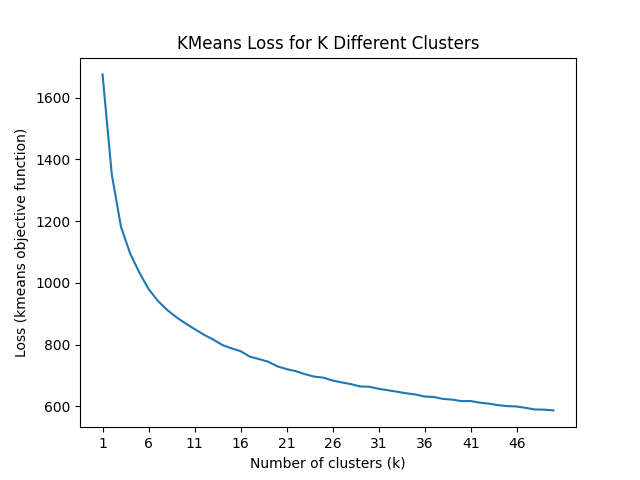

In [23]:
# plot the loss as a function of the number of cluster centers (k)
x = np.arange(max_num_clusters) + 1
y = loss_arr
fig, ax = plt.subplots()
ax.set_title("KMeans Loss for K Different Clusters")
ax.set_xlabel('Number of clusters (k)')
ax.set_ylabel('Loss (kmeans objective function)')
ax.plot(x,y)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(1, max_num_clusters+1, 5))
plt.show()

In [24]:
# plot the distribution of the normalized death rate 
## this is useful to inform us about how we choose our "risk bins"

hist = np.histogram(all_data[:,41], bins=20)
plt.bar(np.arange(20), hist[0], color='green')
plt.show()

In [25]:
# choose the way we want to define these risk bins

sorted_by_target_val = all_data[np.argsort(all_data[:,41])]

# METHOD 1: assign bins with approx. equal number of points per bin
num_bins = 4
actual_bins = []
for i in range(num_bins):
    start = int((all_data.shape[0] / num_bins) * i)
    stop = int((all_data.shape[0] / num_bins) * (i+1))
    actual_bins.append(sorted_by_target_val[start:stop,:])
# get info about range (of target value) of each bin
bin_ranges = []
for i in range(num_bins):
    min_val = np.min(actual_bins[i][:,41])
    max_val = np.max(actual_bins[i][:,41])
    bin_ranges.append([min_val, max_val])
    print("Bin {} range of values: {} - {}".format(i, min_val, max_val))

Bin 0 range of values: 0.0 - 0.14131193300767622
Bin 1 range of values: 0.1414863921842289 - 0.2027215631542219
Bin 2 range of values: 0.2027215631542219 - 0.27581995812979765
Bin 3 range of values: 0.27599441730635027 - 1.0


In [26]:
# find the avg death rate per cluster, and assign it to the appropriate bin

# number of optimal clusters
num_optimal_clusters = 6
# use k=6, because that's what we found to be ideal (well not really... just using naked eye)
kmeans = sklearn.cluster.KMeans(n_clusters=num_optimal_clusters).fit(data)
labels = kmeans.labels_
clusters = kmeans.cluster_centers_
loss = kmeans.inertia_
n_iter = kmeans.n_iter_

# initialize the dictionary
avg_death_clusters = {}
for i in range(num_optimal_clusters):
    avg_death_clusters[i] = 0.0

# get the avg death rate for each cluster, and display
for i in range(labels.shape[0]):
    cluster_number = labels[i]
    death_rate = all_data[i, 41]
    avg_death_clusters[cluster_number] += death_rate
bincount = np.bincount(labels)
for i in range(num_optimal_clusters):
    avg_death_clusters[i] = avg_death_clusters[i] / bincount[i]
# print(avg_death_clusters)

# assign each cluster a bin, and display
bin_assignments = np.zeros(num_optimal_clusters)
for i in range(num_optimal_clusters):
    for j in range(len(bin_ranges)):
        if avg_death_clusters[i] < bin_ranges[j][1]:
            bin_assignments[i] = j
            break
# print(bin_assignments)

# for each cluster, find the accuracy of the bin assignments 
## (number of points that agree with bin assignment / all points)
### go through all points, check if target is in same bin as cluster (this means correct classif.)
num_correctly_classified = 0
for i in range(len(all_data)):
    point_cluster_label = labels[i]
    cluster_bin_index = bin_assignments[point_cluster_label].astype(int)
    if all_data[i,41] < bin_ranges[cluster_bin_index][1] and all_data[i,41] >= bin_ranges[cluster_bin_index][0]:
        num_correctly_classified += 1
    elif all_data[i,41] == 1.0 and cluster_bin_index == len(bin_ranges)-1:
        num_correctly_classified += 1

# display the accuracy score
print("Correctly classified {} points".format(num_correctly_classified))
print("Accuracy: {}".format(num_correctly_classified / len(all_data)))

Correctly classified 996 points
Accuracy: 0.3747178329571106


In [27]:
def get_bin_ranges(num_bins):
    # choose the way we want to define these risk bins

    sorted_by_target_val = all_data[np.argsort(all_data[:,41])]

    # METHOD 1: assign bins with approx. equal number of points per bin
    actual_bins = []
    for i in range(num_bins):
        start = int((all_data.shape[0] / num_bins) * i)
        stop = int((all_data.shape[0] / num_bins) * (i+1))
        actual_bins.append(sorted_by_target_val[start:stop,:])
    # get info about range (of target value) of each bin
    bin_ranges = []
    for i in range(num_bins):
        min_val = np.min(actual_bins[i][:,41])
        max_val = np.max(actual_bins[i][:,41])
        bin_ranges.append([min_val, max_val])
#         print("Bin {} range of values: {} - {}".format(i, min_val, max_val))
    return bin_ranges

In [28]:

def get_accuracy(num_clusters, bin_ranges):
# find the avg death rate per cluster, and assign it to the appropriate bin

# number of optimal clusters
    num_optimal_clusters = num_clusters
    kmeans = sklearn.cluster.KMeans(n_clusters=num_optimal_clusters).fit(data)
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    loss = kmeans.inertia_
    n_iter = kmeans.n_iter_

    # initialize the dictionary
    avg_death_clusters = {}
    for i in range(num_optimal_clusters):
        avg_death_clusters[i] = 0.0

    # get the avg death rate for each cluster, and display
    for i in range(labels.shape[0]):
        cluster_number = labels[i]
        death_rate = all_data[i, 41]
        avg_death_clusters[cluster_number] += death_rate
    bincount = np.bincount(labels)
    for i in range(num_optimal_clusters):
        avg_death_clusters[i] = avg_death_clusters[i] / bincount[i]

    # assign each cluster a bin, and display
    bin_assignments = np.zeros(num_optimal_clusters)
    for i in range(num_optimal_clusters):
        for j in range(len(bin_ranges)):
            if avg_death_clusters[i] < bin_ranges[j][1]:
                bin_assignments[i] = j
                break

    # for each cluster, find the accuracy of the bin assignments 
    ## (number of points that agree with bin assignment / all points)
    ### go through all points, check if target is in same bin as cluster (this means correct classif.)
    num_correctly_classified = 0
    for i in range(len(all_data)):
        point_cluster_label = labels[i]
        cluster_bin_index = bin_assignments[point_cluster_label].astype(int)
        if all_data[i,41] < bin_ranges[cluster_bin_index][1] and all_data[i,41] >= bin_ranges[cluster_bin_index][0]:
            num_correctly_classified += 1
        elif all_data[i,41] == 1.0 and cluster_bin_index == len(bin_ranges)-1:
            num_correctly_classified += 1

    # return the accuracy score
    return num_correctly_classified / len(all_data)

In [29]:
# plot the accuracy with respect to the cluster size and number of classification bins (3D graph)

num_clusters = 6
num_classification_bins = 4

accuracy_scores = np.zeros((num_clusters, num_classification_bins))
classification_bins = np.zeros(num_classification_bins)

for k in range(1, num_clusters+1):
    for i in range(1, num_classification_bins+1):
        accuracy_scores[k-1,i-1] = get_accuracy(k, get_bin_ranges(i))

print(accuracy_scores)


[[1.         0.50112867 0.33370956 0.25056433]
 [1.         0.64334086 0.43905192 0.27200903]
 [1.         0.61851016 0.49623777 0.2765237 ]
 [1.         0.68811136 0.49285177 0.34462002]
 [1.         0.68924003 0.5048909  0.34311512]
 [1.         0.67983446 0.49021821 0.37622272]]


(6, 4)
[[1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]
 [4 4 4 4]
 [5 5 5 5]
 [6 6 6 6]]
(6, 4)
[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]
(6, 4)
[[1.         0.50112867 0.33370956 0.25056433]
 [1.         0.64334086 0.43905192 0.27200903]
 [1.         0.61851016 0.49623777 0.2765237 ]
 [1.         0.68811136 0.49285177 0.34462002]
 [1.         0.68924003 0.5048909  0.34311512]
 [1.         0.67983446 0.49021821 0.37622272]]


<IPython.core.display.Javascript object>


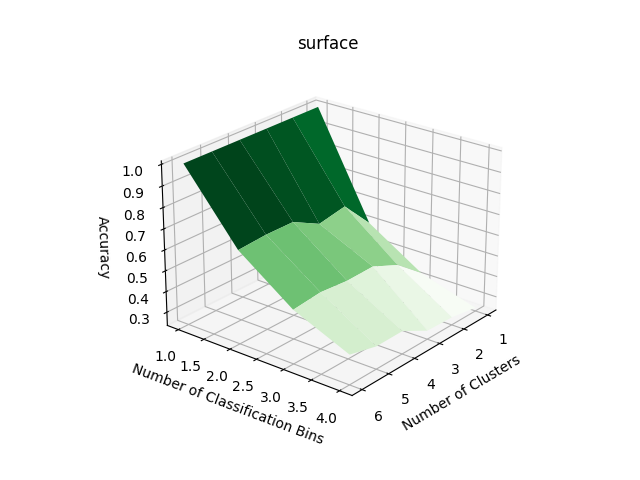

In [31]:
X = np.broadcast_to(np.arange(1, num_clusters+1, 1), (4,6)).T
Y = np.broadcast_to(np.arange(1, num_classification_bins+1, 1), (6,4))
XX, YY = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
Z = accuracy_scores

print(X.shape)
print(X)
print(Y.shape)
print(Y)
print(Z.shape)
print(Z)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='Greens', edgecolor='none')
ax.set_title('surface')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Number of Classification Bins')
ax.set_zlabel('Accuracy');

In [43]:
# dimensionality reduction????
# latent dirichlet allocation

# use pca, and then compared accuracy to what we currently have
# compare those insights to randomly selected feature columns

## Try using PCA to reduce the number of dimensions

In [44]:
# try PCA on the normalized dataset
all_data = np.load('normalized_clean_data.npy')

pca = PCA(n_components=5)
reduced_dims_dataset = pca.fit_transform(all_data[:,:all_data.shape[1]-1])
# append the normalized target value
reduced_dims_dataset = np.append(reduced_dims_dataset, np.array([all_data[:,41]]).T, axis=1)
np.save('reduced_dims_dataset.npy', reduced_dims_dataset)

In [45]:
all_data = np.load('reduced_dims_dataset.npy')

# exclude the target value from the dataset
data = all_data[:,:all_data.shape[1]-1]

In [46]:
# run kmeans algorithm multiple times to observe the loss values at each k value
max_num_clusters = 50
loss_arr = np.zeros(max_num_clusters)
for k in range(1, max_num_clusters+1):
    kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(data)
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    loss = kmeans.inertia_
    n_iter = kmeans.n_iter_
    loss_arr[k-1] = loss

<IPython.core.display.Javascript object>


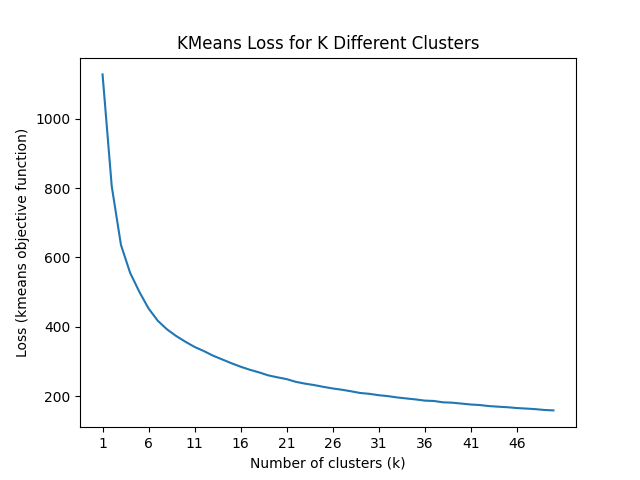

In [49]:
# plot the loss as a function of the number of cluster centers (k)
x = np.arange(max_num_clusters) + 1
y = loss_arr
fig, ax = plt.subplots()
ax.set_title("KMeans Loss for K Different Clusters")
ax.set_xlabel('Number of clusters (k)')
ax.set_ylabel('Loss (kmeans objective function)')
ax.plot(x,y)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(1, max_num_clusters+1, 5))
plt.show()

In [50]:
# plot the distribution of the normalized death rate 
## this is useful to inform us about how we choose our "risk bins"

hist = np.histogram(all_data[:,all_data.shape[1]-1], bins=20)
plt.bar(np.arange(20), hist[0], color='green')
plt.show()

In [51]:
# choose the way we want to define these risk bins

sorted_by_target_val = all_data[np.argsort(all_data[:,all_data.shape[1]-1])]

# METHOD 1: assign bins with approx. equal number of points per bin
num_bins = 4
actual_bins = []
for i in range(num_bins):
    start = int((all_data.shape[0] / num_bins) * i)
    stop = int((all_data.shape[0] / num_bins) * (i+1))
    actual_bins.append(sorted_by_target_val[start:stop,:])
# get info about range (of target value) of each bin
bin_ranges = []
for i in range(num_bins):
    min_val = np.min(actual_bins[i][:,all_data.shape[1]-1])
    max_val = np.max(actual_bins[i][:,all_data.shape[1]-1])
    bin_ranges.append([min_val, max_val])
    print("Bin {} range of values: {} - {}".format(i, min_val, max_val))

Bin 0 range of values: 0.0 - 0.14131193300767622
Bin 1 range of values: 0.1414863921842289 - 0.2027215631542219
Bin 2 range of values: 0.2027215631542219 - 0.27581995812979765
Bin 3 range of values: 0.27599441730635027 - 1.0


In [52]:
# find the avg death rate per cluster, and assign it to the appropriate bin

# number of optimal clusters
num_optimal_clusters = 8
# use k=6, because that's what we found to be ideal (well not really... just using naked eye)
kmeans = sklearn.cluster.KMeans(n_clusters=num_optimal_clusters).fit(data)
labels = kmeans.labels_
clusters = kmeans.cluster_centers_
loss = kmeans.inertia_
n_iter = kmeans.n_iter_

# initialize the dictionary
avg_death_clusters = {}
for i in range(num_optimal_clusters):
    avg_death_clusters[i] = 0.0

# get the avg death rate for each cluster, and display
for i in range(labels.shape[0]):
    cluster_number = labels[i]
    death_rate = all_data[i, all_data.shape[1]-1]
    avg_death_clusters[cluster_number] += death_rate
bincount = np.bincount(labels)
for i in range(num_optimal_clusters):
    avg_death_clusters[i] = avg_death_clusters[i] / bincount[i]
# print(avg_death_clusters)

# assign each cluster a bin, and display
bin_assignments = np.zeros(num_optimal_clusters)
for i in range(num_optimal_clusters):
    for j in range(len(bin_ranges)):
        if avg_death_clusters[i] < bin_ranges[j][1]:
            bin_assignments[i] = j
            break
# print(bin_assignments)

# for each cluster, find the accuracy of the bin assignments 
## (number of points that agree with bin assignment / all points)
### go through all points, check if target is in same bin as cluster (this means correct classif.)
num_correctly_classified = 0
for i in range(len(all_data)):
    point_cluster_label = labels[i]
    cluster_bin_index = bin_assignments[point_cluster_label].astype(int)
    if all_data[i,all_data.shape[1]-1] < bin_ranges[cluster_bin_index][1] and all_data[i,all_data.shape[1]-1] >= bin_ranges[cluster_bin_index][0]:
        num_correctly_classified += 1
    elif all_data[i,all_data.shape[1]-1] == 1.0 and cluster_bin_index == len(bin_ranges)-1:
        num_correctly_classified += 1

# display the accuracy score
print("Correctly classified {} points".format(num_correctly_classified))
print("Accuracy: {}".format(num_correctly_classified / len(all_data)))

Correctly classified 1000 points
Accuracy: 0.3762227238525207


In [60]:
def get_bin_ranges(num_bins):
    # choose the way we want to define these risk bins

    sorted_by_target_val = all_data[np.argsort(all_data[:,all_data.shape[1]-1])]

    # METHOD 1: assign bins with approx. equal number of points per bin
    actual_bins = []
    for i in range(num_bins):
        start = int((all_data.shape[0] / num_bins) * i)
        stop = int((all_data.shape[0] / num_bins) * (i+1))
        actual_bins.append(sorted_by_target_val[start:stop,:])
    # get info about range (of target value) of each bin
    bin_ranges = []
    for i in range(num_bins):
        min_val = np.min(actual_bins[i][:,all_data.shape[1]-1])
        max_val = np.max(actual_bins[i][:,all_data.shape[1]-1])
        bin_ranges.append([min_val, max_val])
#         print("Bin {} range of values: {} - {}".format(i, min_val, max_val))
    return bin_ranges

In [63]:

def get_accuracy(num_clusters, bin_ranges):
# find the avg death rate per cluster, and assign it to the appropriate bin

# number of optimal clusters
    num_optimal_clusters = num_clusters
    kmeans = sklearn.cluster.KMeans(n_clusters=num_optimal_clusters).fit(data)
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    loss = kmeans.inertia_
    n_iter = kmeans.n_iter_

    # initialize the dictionary
    avg_death_clusters = {}
    for i in range(num_optimal_clusters):
        avg_death_clusters[i] = 0.0

    # get the avg death rate for each cluster, and display
    for i in range(labels.shape[0]):
        cluster_number = labels[i]
        death_rate = all_data[i, all_data.shape[1]-1]
        avg_death_clusters[cluster_number] += death_rate
    bincount = np.bincount(labels)
    for i in range(num_optimal_clusters):
        avg_death_clusters[i] = avg_death_clusters[i] / bincount[i]

    # assign each cluster a bin, and display
    bin_assignments = np.zeros(num_optimal_clusters)
    for i in range(num_optimal_clusters):
        for j in range(len(bin_ranges)):
            if avg_death_clusters[i] < bin_ranges[j][1]:
                bin_assignments[i] = j
                break

    # for each cluster, find the accuracy of the bin assignments 
    ## (number of points that agree with bin assignment / all points)
    ### go through all points, check if target is in same bin as cluster (this means correct classif.)
    num_correctly_classified = 0
    for i in range(len(all_data)):
        point_cluster_label = labels[i]
        cluster_bin_index = bin_assignments[point_cluster_label].astype(int)
        if all_data[i,all_data.shape[1]-1] < bin_ranges[cluster_bin_index][1] and all_data[i,all_data.shape[1]-1] >= bin_ranges[cluster_bin_index][0]:
            num_correctly_classified += 1
        elif all_data[i,all_data.shape[1]-1] == 1.0 and cluster_bin_index == len(bin_ranges)-1:
            num_correctly_classified += 1

    # return the accuracy score
    return num_correctly_classified / len(all_data)

In [64]:
# plot the accuracy with respect to the cluster size and number of classification bins (3D graph)

num_clusters = 8
num_classification_bins = 4

accuracy_scores = np.zeros((num_clusters, num_classification_bins))
classification_bins = np.zeros(num_classification_bins)

for k in range(1, num_clusters+1):
    for i in range(1, num_classification_bins+1):
        accuracy_scores[k-1,i-1] = get_accuracy(k, get_bin_ranges(i))

print(accuracy_scores)


[[1.         0.50112867 0.33370956 0.25056433]
 [1.         0.64484575 0.43942814 0.27276147]
 [1.         0.62039127 0.4917231  0.27878104]
 [1.         0.68698269 0.51203913 0.28630549]
 [1.         0.68585403 0.50790068 0.28592927]
 [1.         0.68322047 0.49623777 0.36343115]
 [1.         0.665538   0.53160271 0.36568849]
 [1.         0.67832957 0.5048909  0.37735139]]


(8, 4)
[[1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]
 [4 4 4 4]
 [5 5 5 5]
 [6 6 6 6]
 [7 7 7 7]
 [8 8 8 8]]
(8, 4)
[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]
(8, 4)
[[1.         0.50112867 0.33370956 0.25056433]
 [1.         0.64484575 0.43942814 0.27276147]
 [1.         0.62039127 0.4917231  0.27878104]
 [1.         0.68698269 0.51203913 0.28630549]
 [1.         0.68585403 0.50790068 0.28592927]
 [1.         0.68322047 0.49623777 0.36343115]
 [1.         0.665538   0.53160271 0.36568849]
 [1.         0.67832957 0.5048909  0.37735139]]


<IPython.core.display.Javascript object>


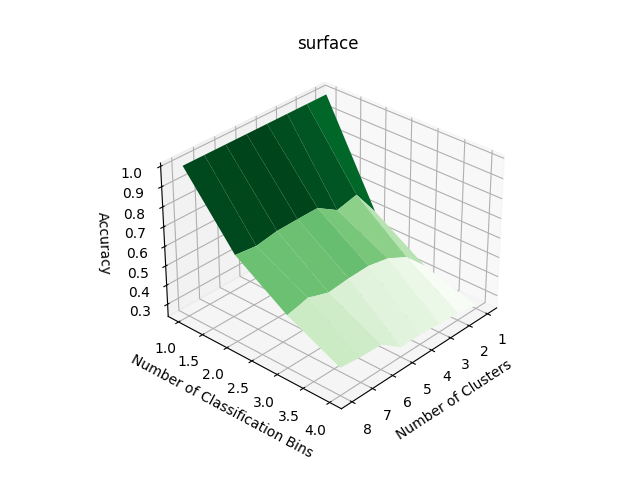

In [66]:
X = np.broadcast_to(np.arange(1, num_clusters+1, 1), (num_classification_bins,num_clusters)).T
Y = np.broadcast_to(np.arange(1, num_classification_bins+1, 1), (num_clusters,num_classification_bins))
XX, YY = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
Z = accuracy_scores

print(X.shape)
print(X)
print(Y.shape)
print(Y)
print(Z.shape)
print(Z)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='Greens', edgecolor='none')
ax.set_title('surface')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Number of Classification Bins')
ax.set_zlabel('Accuracy');